<a href="https://colab.research.google.com/github/ftc8569/2020-ftc-vision/blob/master/FindRings_Initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ensure that the proper packages are intalled.

In [ ]:
!pip install opencv-python
!pip install numpy
!pip install matplotlib

Now clone our github repo to get all of our files.  To get the path to a file, find it in the file browser to the left.  Then, right click it and select "Copy File Path" and paste that path into the code block.

In [ ]:
# Clone the entire repo.  Here I set the destination path to "/content/drive/My Drive/2020-ftc-vision" which is my mounted google drive
# if you want to just create a temporary folder (that will be recylced when the runtime restarts), set the path to just "2020-ftc-vision"
!git clone https://github.com/ftc8569/2020-ftc-vision.git  "/content/drive/My Drive/2020-ftc-vision"
%cd "/content/drive/My Drive/2020-ftc-vision"
!ls

fatal: destination path '/content/drive/My Drive/2020-ftc-vision' already exists and is not an empty directory.
/content/drive/My Drive/2020-ftc-vision
LICENSE  misc  opencv  README.md


Import the necessary libraries.  Note that opencv's cv2.imshow crashed colab notebooks so we import a patched version as "cv2_imshow" and we use that one.

In [ ]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

Now let's do some computer vision!  Load the image file and resize it to 640x480 (just to make it more managable).  The early image taken by Eli are huge.

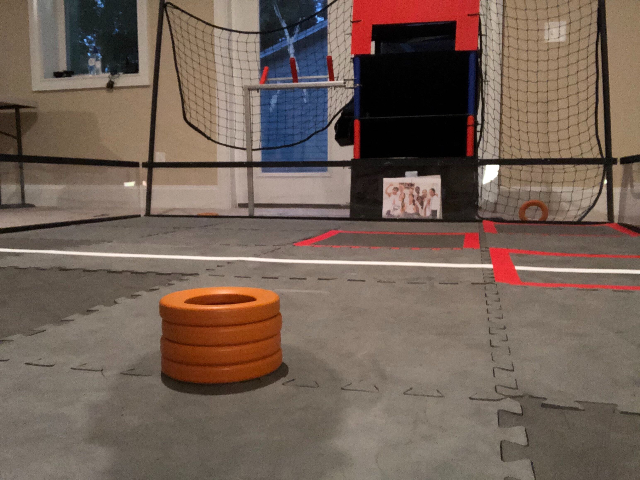

In [ ]:
# See https://www.youtube.com/watch?v=WQeoO7MI0Bs
# chapter 7 masking an image
# chapter 8 contours 

img = cv2.imread('/content/drive/My Drive/2020-ftc-vision/opencv/four-rings.jpg')
# img = cv2.imread('/content/2020-ftc-vision/opencv/one-ring.jpg')
# img = cv2.imread('/content/2020-ftc-vision/opencv/no-rings.jpg')

imgResize = cv2.resize(img,(640,480))
cv2_imshow(imgResize)

Now let's convert this image from BGR (opencv stores images in blue, gree, red format) into HSV.  See this wiki page on HSV - https://en.wikipedia.org/wiki/HSL_and_HSVhttps://en.wikipedia.org/wiki/HSL_and_HSV.

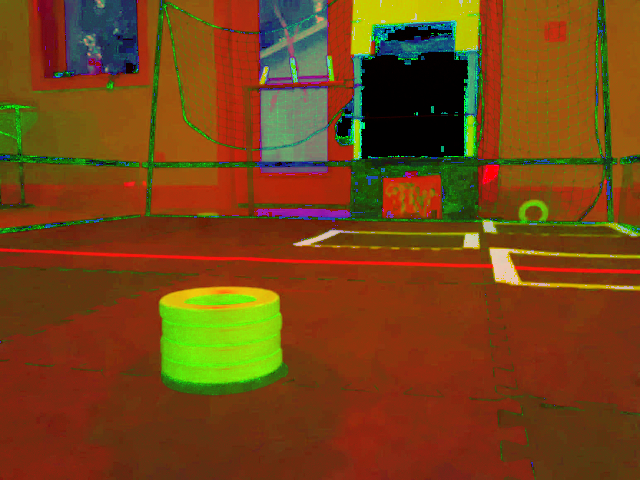

In [ ]:
imgHSV = cv2.cvtColor(imgResize, cv2.COLOR_BGR2HSV)
cv2_imshow(imgHSV)

Now we want to filter this image based on the values of hue, saturation, and value (hsv).  After some experimentation, I found that these worked best:

* 6 < h < 67
* 155 < s < 255
* 70 < v < 255


You will note that these are formed into two arrays: one with the lower bound values and one with the upper bound values. 

We create a "mask" by calling cv2.inRange(...) - this function creates a matric with 255's (8-bit all 1's) where the HSV values of the original image are in the specified range and 0's where it is not.

Here the 255's appear at bright white and the 0's are black.

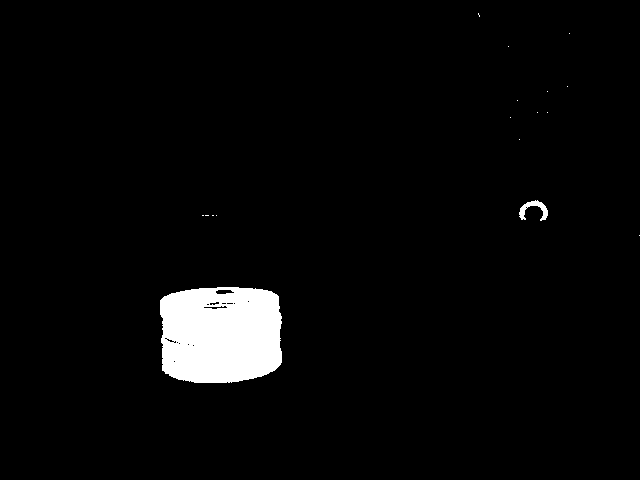

In [ ]:
lower = np.array([6,155,70])
upper = np.array([67,255,255])
# lower = np.array([0,0,0])
# upper = np.array([255,255,255])
mask = cv2.inRange(imgHSV, lower, upper)
cv2_imshow(mask)

Now, see the small speckles.  These are sometimes called "salt & pepper."  They represent pixels are a few pixels that somehow met our range criteria.  We need to fitler them out of our mask.  Generally, this is done some sort of "blur" function. (The main other alternative is to erode and then dilate the image.) 

Here, the simplest thing is to do a medianBlur.  Here you specify the size of a "kernel" which must be an odd number.  If we specified a kernel size of 3, for example, the computer will construct a 3x3 matrix, like a a tic-tac-toe board, with the pixel of interest in the middle square (this is why the kernel size must be odd...so that there is a middle square).  The computer them moves this tic-tac-toe board across the image so that each pixel is the center square.  The medianBlur, simply makes the new center pixel the median value of all pixels in the 3x3 kernel surrounding it.  

With our mask, every pixel has a value of either 255 (inRange was true) or 0 (inRange was false).  So, this median becomes a simple voting mechanism.  Are there more 255's or 0's in the kernel surrounding a pixel.  Here, a single isolated 255 pixel, surrounded by 8 0 pixels, would have a median value of 0, turning that pixel off.  However, if a 255 pixel is surrounded by at least 4 other adjacent 255 pixels, then it stays on.  You can see how this will filter out isolated single pixels (either 255 or 0).

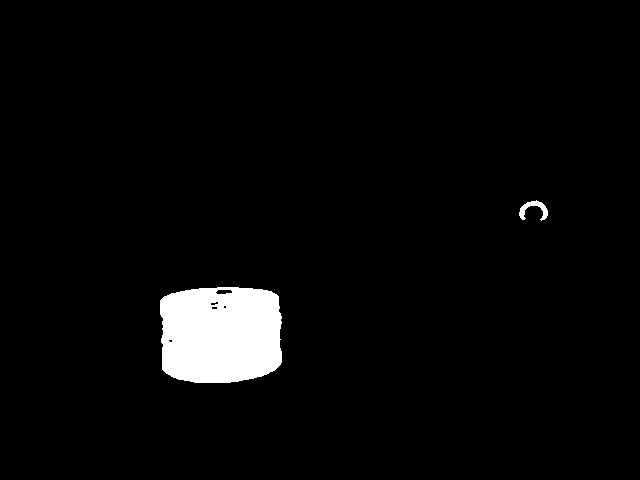

In [ ]:
blurMask = cv2.medianBlur(mask,3)
cv2_imshow(blurMask)

Now we find the contours the cannyImage.  The contours are the mathematical version of the image.  We can then convert those contours into polygons (sets of points) and if we want to, we can even determine the bounding rectangles from those polygons.

opencv has a useful function that calculates the area of the contours.

In [ ]:
# find the bounding rectangles
contours, hierarchy = cv2.findContours(blurMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
ringContourArea = 0
ringFound = False
rects = []
areas = []
for c in contours:
  contourArea = cv2.contourArea(c)
  areas.append(contourArea)
  poly = cv2.approxPolyDP(c,3,True)
  rect = cv2.boundingRect(poly)
  rects.append(rect)
  if (contourArea > ringContourArea and contourArea > 1000):
    ringFound = True
    ringContourArea = contourArea
    ringContour = c
    ringBoundingRect = rect

print(areas)

[10428.5, 192.0]


For the initial set of images that Eli captured, the largest area was always the rings and when there are more rings, guess what? There is more area.  Here are the largest areas detected for each image:

* Four Rings:  10522
* One Ring:     5513
* No Ring:        ~0

So this set up a simple heuristic: only call it a ring if area is above 1000.  If there is a ring-colored blob, if it is above 7500, call it four rings, otherwise call it one-ring.

In [ ]:
if (ringFound):
     if(ringContourArea < 7500):
          print("Found One Ring")
     else:
          print("Found Four Rings")
     print(ringContourArea)
     print(ringBoundingRect)
else:
     print("Found No Rings")


Found Four Rings
10522.5
(161, 287, 121, 96)
